In [ ]:
- https://kavita-ganesan.com/fasttext-vs-word2vec/#.YVAOfLgzZPY
- https://amitness.com/2020/06/fasttext-embeddings/

# FastText

FastText ise 2016 yılında Facebook tarafından geliştirilen Word2Vec tabanlı bir modeldir. FastText ve Word2Vec kavramsal olarak aynıdırlar, ancak aralarında küçük bir fark vardır; FastText karakter düzeyinde çalışırken Word2ec kelime düzeyinde çalışır. Dolayısıyla Word2Vec, eğitilecek en küçük birim olarak kelimeleri ele alırken, FastText en küçük birim olarak n-gram karakterleri kullanır. Kelimeler n-gram vektörlerinin toplamı ile temsil edilir. 

fastText Word2ec'in aşağıdaki kısıtları için çözüm üretmektedir.

- Word2Vec'te her kelime için bir gömme oluşturulur. Dolayısıyla eğitimi sırasında karşılaşmadığı hiçbir kelimeyi işleyemez.
- Aynı köklere sahip kelimeler için Word2Vec herhangi bir parametre paylaşımı yapmaz. Her kelime, göründüğü bağlama göre benzersiz bir şekilde öğrenilir.




<div>
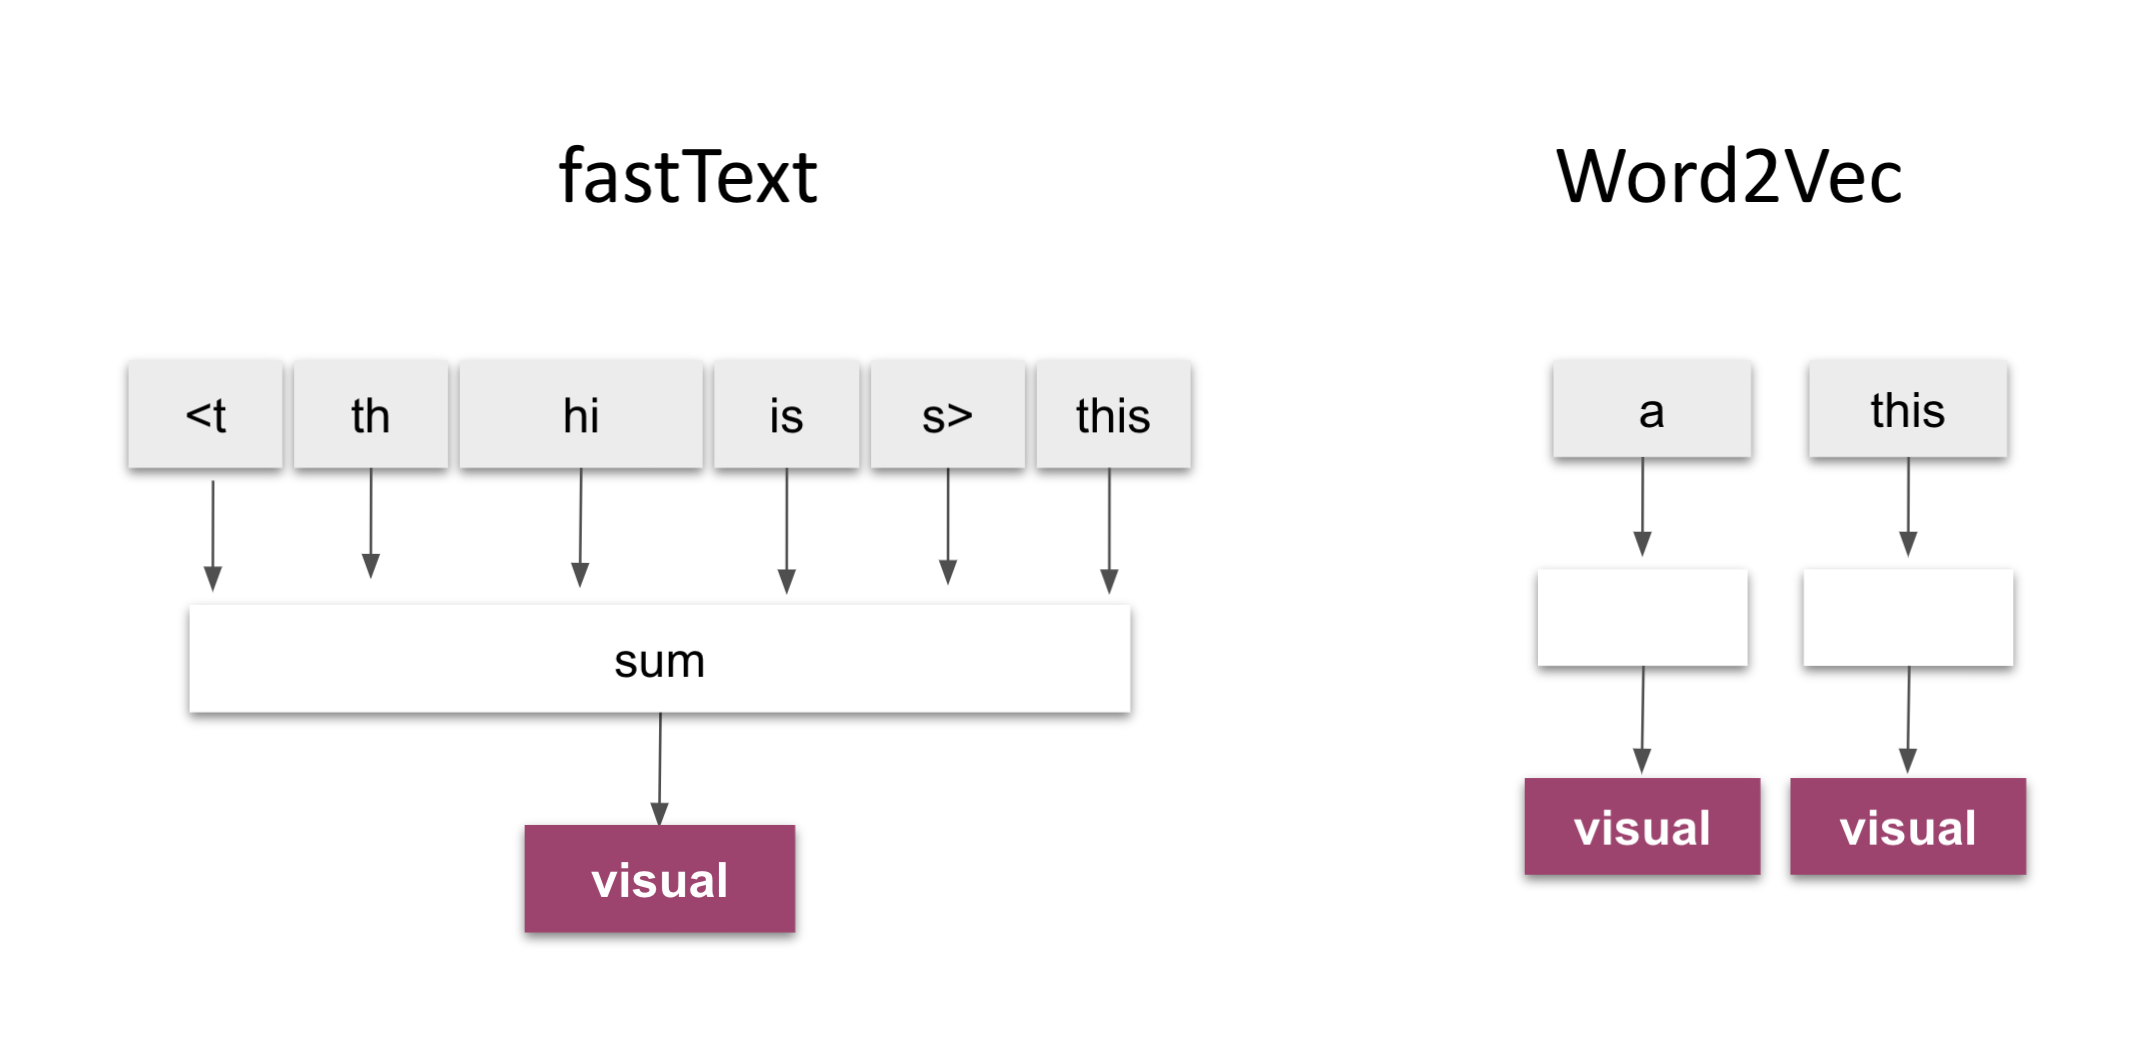
</div>

                           - https://kavita-ganesan.com/fasttext-vs-word2vec/#.YVAOfLgzZPY

**Bir n-gram karakter çantası, bir kelimenin n-gram karakter toplamı ile temsil edildiği anlamına gelir. Örneğin n=3 ve kelimenin "eating" olduğu durumda, ortaya çıkan n-gramlar şöyle olacaktır:**

<div>
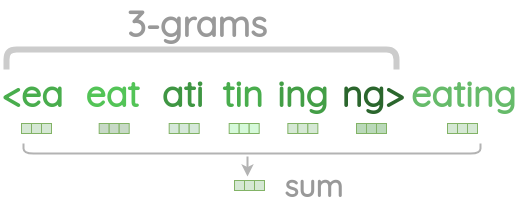
</div>

                                    - https://amitness.com/2020/06/fasttext-embeddings/
                                                        
                                                      
 
**n'in farklı boyutları için karakter n-gram'ları aşağıdaki gibi gerçekleşecektir.**

<div>
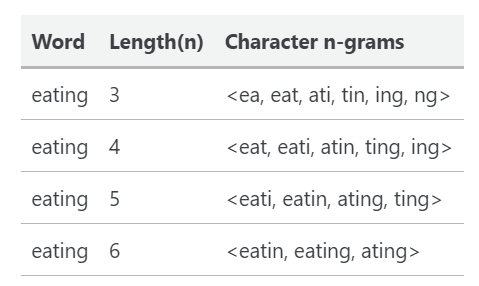
</div>

                                    - https://amitness.com/2020/06/fasttext-embeddings/

Orjinal makalede yazarlar, n>=3 ve n<=6 ile n-gram kullanmanın en iyi sonucu verdiğini bulmuşlardır. Ancak optimal n-gram boyutu göreve ve dile bağlıdır ve buna uygun şekilde ayarlanmalıdır.  

fastText'in arkasındaki sezgi, bir n-gram karakter çantası kullanarak, morfolojik olarak zengin dillerin temsillerini öğrenebilmenizdir. Orijinal fastText makalesinden yazarlar, n-gram karakterlerinin kullanımının Arapça, Almanca ve Rusça gibi morfolojik olarak zengin dillerde İngilizce'den daha yararlı olduğunu bulmuşlardır. 

Örneğin, Almanca gibi dillerde belirli ifadeler tek bir kelime olarak ifade edilir. Örneğin masa tenisi ifadesi Tischtennis olarak yazılmıştır. Word2Vec'te tenis ve tischtennis temsili ayrı ayrı öğrenilir. Bu, tenis ve tischtennis'in aslında ilişkili olduğu sonucunu çıkarmayı zorlaştırıyor.

Bununla birlikte, bu kelimelerin karakter n-gram temsilini öğrenerek, tenis ve tischtennis artık örtüşen n-gramları paylaşacak ve onları vektör uzayında daha yakın hale getirecektir. N-gram karakter vektörleri başka kelimelerle paylaşıldığı için ilişkili kelimelerin ortaya çıkarılması kolaylaşmaktadır.

Karakter n-gram gösteriminin başka bir kullanımı, eğitim sırasında görünmeyen kelimeler için de kelime gömmeleri oluşturabilmesidir.


Modelin en önemli parametrelerinden biri de vektör boyutudur. Vektör boyutu ne kadar büyükse o kadar fazla bilgi yakalayabilirler ancak öğrenme için daha fazla veri gerektirir. Ancak vektör boyutu çok büyük olması eğitim süresini uzatacaktır. Varsayılan olarak 100 boyut kullanılmaktadır, ancak 100-300 aralığındaki değerler en çok kullanılan değerlerdir. 

Epoch parametresi ise, modelin veriler üzerinde kaç kez döngü yapacağını kontrol eder.

fastText, kelime temsillerini hesaplamak için skipgram ve cbow modellerini kullanır. Bir sonraki aşamada Vikipedi'de yer alan türkçe klasik romanlara ait sayfalardan oluşan corpus üzerinde fastText cbow ve skipggram modellerini oluşturup Word2Vec modelleri karşılaştıracağız.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')



In [2]:
# import required modules
# Beautfulsoup: HTML ve XML dosyalarından veri çekmek için bir Python kütüphanesidir.
# lxml: XML ve HTML dosyalarını işlememizi sağlayan bir Python kütüphanesidir.
# request : HTTP/1.1 isteklerini kolay bir şekilde göndermenizi sağlar.

from bs4 import BeautifulSoup
import requests
import pandas as pd
import re

#conda install -c conda-forge spacy==2.3.1
#pip install spacy[lookups]
#kernel restart

import spacy
from spacy.lang.tr import Turkish
nlp = Turkish()

import nltk
WPT = nltk.WordPunctTokenizer()


# Vikipedi - Türkçe Klasik Romalar Sayfaları Verisi

In [3]:
webs = requests.get('https://tr.wikipedia.org/wiki/Kategori:Klasik_T%C3%BCrk_romanlar%C4%B1').content
soup=BeautifulSoup(webs,'html.parser')

In [4]:
print(set([text.parent.name for text in soup.find_all(text=True)]))

{'html', 'h2', 'script', 'span', 'a', 'p', 'label', 'title', 'ul', 'header', 'li', 'h3', 'div', 'main', 'nav', 'footer', '[document]', 'input', 'form', 'body', 'h1', 'head'}


In [5]:
Page_List = []
items = soup.find_all('div', class_="mw-content-ltr")
for item in items:
    links = item.find_all('a')
    for link in links:
        if link.parent.name == 'li':
            Page_List.append(link.text)

In [6]:
def viki_parser(page_name):
    request = requests.get('https://tr.wikipedia.org/wiki/'+page_name).content
    if request is not None:
        soup = BeautifulSoup(request, 'html.parser')
        title = soup.select("#firstHeading")[0].text
        paragraphs = soup.select("p")
        text = '\n'.join([ para.text for para in paragraphs[1:]])
    return title, text

In [7]:
def viki_df(page_list):
    Title = []; Text = []
    for i in page_list:
        title, text = viki_parser(i)
        Title.append(title)
        Text.append(text)
        df = pd.DataFrame(list(zip(Title, Text)), columns =["Title","Text"])
    return df


In [8]:
df = viki_df(Page_List)
df.head()

,Title,Text
0,Acımak (roman),"Acımak, Reşat Nuri Güntekin'in 1928 yılında ba..."
1,Akabi Hikâyesi,"Akabi Hikâyesi, Osmanlı Ermenisi Vartan Paşa t..."
2,Araba Sevdası,"Araba Sevdası, Recaizade Mahmud Ekrem'in 1898 ..."
3,Aşk-ı Memnu,"Aşk-ı Memnu (günümüz Türkçesi: Yasak Aşk), Hal..."
4,Ateşten Gömlek,"Ateşten Gömlek, Halide Edip Adıvar'ın bir roma..."


### NLP Preprocessing

In [9]:
def cleaning_text(text):
    text_nobracket = re.sub(".*?\((.*?)\)", '', str(text.lower()))
    text_nopunct = re.sub(r'[^\w\s]','', str(text_nobracket))
    text_nonumbers =re.sub('[0-9]+', '', str(text_nopunct))
    return text_nonumbers

# func. definition for getting the root of the each normalized text
def lemma(Text):
    Lemma=[]
    doc= nlp(Text)
    for word in doc:
        Lemma.append(word.lemma_)
    return ' '.join(Lemma)

text_file = open("zemberek_stopwords.txt", "r")
stopwords_zemberek = text_file.read().split('\n')
len(stopwords_zemberek)

def tokenize(text):
    tokens = WPT.tokenize(text)
    return tokens



In [10]:
#cleaning punctuation  numbers
df.loc[:,'Text_Preprocessing'] = df.loc[:,'Text'].apply(lambda x: cleaning_text(x))

#lemmatization
df.loc[:,'Text_Preprocessing'] = df.loc[:,'Text_Preprocessing'].apply(lambda x: lemma(x))

#cleaning stop words
df.loc[:,'Text_Preprocessing'] = df.loc[:,'Text_Preprocessing']\
    .apply(lambda x: " ".join(x for x in str(x).split() if x not in stopwords_zemberek))

#tokenizing
df.loc[:,'Text_Token'] = df.loc[:,'Text_Preprocessing'].apply(lambda x: tokenize(x) )

df.head()

,Title,Text,Text_Preprocessing,Text_Token
0,Acımak (roman),"Acımak, Reşat Nuri Güntekin'in 1928 yılında ba...",acı reşat nuri güntekin yıl bas kısa soluk rom...,"[acı, reşat, nuri, güntekin, yıl, bas, kısa, s..."
1,Akabi Hikâyesi,"Akabi Hikâyesi, Osmanlı Ermenisi Vartan Paşa t...",diğer açı helmuth von moltkenin dil kültür gel...,"[diğer, açı, helmuth, von, moltkenin, dil, kül..."
2,Araba Sevdası,"Araba Sevdası, Recaizade Mahmud Ekrem'in 1898 ...",araba sevda recaizade mahmud ekrem yıl yayımla...,"[araba, sevda, recaizade, mahmud, ekrem, yıl, ..."
3,Aşk-ı Memnu,"Aşk-ı Memnu (günümüz Türkçesi: Yasak Aşk), Hal...",halid ziya uşaklıgilin realistnaturalist roman...,"[halid, ziya, uşaklıgilin, realistnaturalist, ..."
4,Ateşten Gömlek,"Ateşten Gömlek, Halide Edip Adıvar'ın bir roma...",ateş gömlek halide et adıvar roman ol ikdam ga...,"[ateş, gömlek, halide, et, adıvar, roman, ol, ..."


# fastText Models

**Model verilecek olan metin verisi aşağgıdaki gibi list in list formatında olmalı.**

sentence = [["cat", "say", "meow"], ["dog", "say", "woof"]]

sentences = [row.split(" ") for row in wiki_df['Article']]

In [11]:
import gensim
from gensim.models.fasttext import FastText

# fastText CBOW Model

In [12]:
cbow_fasttext = FastText(df["Text_Token"], vector_size=400, window=7, min_count =5,  min_n=3, max_n=6)
%time cbow_fasttext.train(df["Text_Token"],total_examples=len(df["Text_Token"]), epochs=400)

Wall time: 1min 12s


(4713807, 7356800)

# fastText SkipGram Model

In [13]:
skipgram_fasttext = FastText(df["Text_Token"],vector_size=400, window=7, min_count =5, min_n=3, max_n=6, sg = 1) # sg=1 skip-gram seçimi
%time skipgram_fasttext.train(df["Text_Token"],total_examples=len(df["Text_Token"]),epochs=400)

Wall time: 1min 17s


(4713303, 7356800)

# Modeli Kaydetme ve Okuma

### Kaydetme

In [14]:
#fasttext_cbow.wv.save("cbow_fasttext.bin")
#fasttext_skipgram.wv.save("skipgram_fasttext.bin")

### Okuma 

In [15]:
#cbow_fasttext = KeyedVectors.load("fasttext_cbow.bin")
#skipgram_fasttext = KeyedVectors.load("fasttext_skipgram.bin")

In [16]:
cbow_fasttext.wv.most_similar("roman", topn =5)

[('romantik', 0.6293008923530579),
 ('romantizm', 0.592154324054718),
 ('romancılık', 0.5157119035720825),
 ('edebiyat', 0.41199028491973877),
 ('selim', 0.32527998089790344)]

In [17]:
skipgram_fasttext.wv.most_similar("roman", topn =5)

[('türk', 0.3051208257675171),
 ('edebiyat', 0.30444690585136414),
 ('karakter', 0.29362818598747253),
 ('romantik', 0.27977848052978516),
 ('toplumsal', 0.2755753993988037)]

In [18]:
cbow_fasttext.wv.most_similar(positive=["şair","yazar"],negative=["şiir"])

[('yazı', 0.3451383113861084),
 ('istanbulda', 0.3382697105407715),
 ('okuyucu', 0.31124627590179443),
 ('eser', 0.3108944594860077),
 ('selim', 0.306016206741333),
 ('torun', 0.29112139344215393),
 ('geçer', 0.2849319875240326),
 ('ii', 0.27790212631225586),
 ('asker', 0.2747512757778168),
 ('ittihat', 0.2717982828617096)]

# fastText vs Word2Vec

### Word2Vec Models

In [19]:
model_cbow = gensim.models.Word2Vec (df["Text_Token"], vector_size=400, window=7, min_count=5)
%time model_cbow.train(df["Text_Token"],total_examples=len(df["Text_Token"]),epochs=400)

Wall time: 9.3 s


(4712762, 7356800)

In [20]:
model_skipgram = gensim.models.Word2Vec (df["Text_Token"], vector_size=400, window=7,min_count=5,  sg=1) # sg=1 skip-gram seçimi
%time model_skipgram.train(df["Text_Token"],total_examples=len(df["Text_Token"]),epochs=500)

Wall time: 43.5 s


(5891939, 9196000)

In [24]:
#model_cbow.wv.save("cbow_vector.bin")
#model_skipgram.wv.save("skipgram_vector.bin")

#cbow_vectors = KeyedVectors.load("cbow_vector.bin")
#skipgram_vectors = KeyedVectors.load("skipgram_vector.bin")

Yazılım kelimesi vikipedi verisi içinde yer almadığı için Word2Vec ile oluşturduğumuz modelde bu kelime için kelime gömmesi oluşturulmaz. Aşağıdaki 

#### Word2Vec Cbow Model

In [25]:
model_cbow.wv.most_similar("yazılım", topn =5)

KeyError: "Key 'yazılım' not present"

In [26]:
cbow_fasttext.wv.most_similar("yazılım", topn =5)

[('yazı', 0.8374184966087341),
 ('yaz', 0.7099267244338989),
 ('yazar', 0.5595723390579224),
 ('rıfat', 0.44205254316329956),
 ('yat', 0.42311567068099976)]

# En Benzer Kelimeler

In [29]:
models = [model_cbow, model_skipgram, cbow_fasttext,skipgram_fasttext]

from IPython.display import display_html

def html_table(html):
    display_html(html.replace('table','table style="padding:20px;display:inline;color:navy;font-size:1.1em"'),raw=True)

def display_similar(models, positive , topn =10):
    col_name = ["cbow_W2V", "sg_W2V", "cbow_ftxt", "sg_ftxt" ]
    html = ""
    for i in range(0, len(models)):
        most_similar =models[i].wv.most_similar(positive, topn = topn)
        html += pd.DataFrame(most_similar,columns=[col_name[i], "cosine"]).to_html()
    html_table(html)


w1=[ "roman"]
display_similar(models, w1, topn =5)

,cbow_W2V,cosine
0,edebiyat,0.373518
1,yazar,0.320565
2,türkiye,0.307687
3,dönem,0.299810
4,selim,0.284987
,sg_W2V,cosine
0,edebiyat,0.290478
1,karakter,0.280992
2,türk,0.265775
3,toplumsal,0.256750


In [30]:
w1=[ "hababam"]
display_similar(models, w1, topn =5)

,cbow_W2V,cosine
0,sınıf,0.628776
1,film,0.446160
2,yazı,0.402057
3,sahne,0.392217
4,şu,0.388917
,sg_W2V,cosine
0,sınıf,0.611375
1,rıfat,0.583349
2,stepne,0.515061
3,sahne,0.505918
